In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [ ]:
import wandb
wandb.init(project="wide-resnet-cifar10", name="wide-resnet")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class WideResNet(nn.Module):
    def __init__(self, depth, width, num_classes=10):
        super(WideResNet, self).__init__()
        assert ((depth - 4) % 6 == 0), 'Depth should be 6n + 4'
        n = (depth - 4) // 6
        k = width

        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(16 * k, n, stride=1)
        self.layer2 = self._make_layer(32 * k, n, stride=2)
        self.layer3 = self._make_layer(64 * k, n, stride=2)
        self.bn = nn.BatchNorm2d(64 * k)
        self.linear = nn.Linear(64 * k, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
# Hyperparameters
depth = 28
width = 10
num_classes = 10
learning_rate = 0.005
epochs = 100
batch_size = 1024
momentum = 0.9
weight_decay = 1e-4

In [ ]:
# Model, Loss, Optimizer
model = WideResNet(depth, width, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


In [ ]:
# Log hyperparameters to wandb
wandb.config.update({
    "depth": depth,
    "width": width,
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "momentum": momentum,
    "weight_decay": weight_decay
})

In [ ]:
# Data Transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Training and Evaluation Functions
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, correct / total

def test(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / total, correct / total

In [ ]:
# Training Loop
best_acc = 0.0
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()
        # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "test_loss": test_loss,
        "test_acc": test_acc
    })

    print(f'Epoch [{epoch + 1}/{epochs}]: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_wrn_model.pth')

print(f'Best Test Accuracy: {best_acc:.4f}')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/100]: Train Loss: 1.8894, Train Acc: 0.2980, Test Loss: 1.6826, Test Acc: 0.3779
Epoch [2/100]: Train Loss: 1.4146, Train Acc: 0.4792, Test Loss: 1.4021, Test Acc: 0.5008
Epoch [3/100]: Train Loss: 1.1558, Train Acc: 0.5828, Test Loss: 1.3417, Test Acc: 0.5253
Epoch [4/100]: Train Loss: 0.9835, Train Acc: 0.6487, Test Loss: 0.9827, Test Acc: 0.6474
Epoch [5/100]: Train Loss: 0.8405, Train Acc: 0.7027, Test Loss: 0.9534, Test Acc: 0.6703
Epoch [6/100]: Train Loss: 0.7351, Train Acc: 0.7439, Test Loss: 0.8464, Test Acc: 0.7125
Epoch [7/100]: Train Loss: 0.6522, Train Acc: 0.7723, Test Loss: 0.7979, Test Acc: 0.7227
Epoch [8/100]: Train Loss: 0.5831, Train Acc: 0.7985, Test Loss: 0.8877, Test Acc: 0.7150
Epoch [9/100]: Train Loss: 0.5344, Train Acc: 0.8147, Test Loss: 0.8860, Test Acc: 0.7207
Epoch [10/100]: Train Loss: 0.4733, Train Acc: 0.8371, Test Loss: 0.7112, Test Acc: 0.7689
Epoch [11/100]: Train Loss: 0.4336, Train Acc: 0.8504, Test Loss: 0.7302, Test Acc: 0.7719
Epoch [1

In [ ]:
wandb.finish()


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁▃▅▆▆▇▅▆▇▇▇▇▇▇█▇████████████████████████
test_loss,█▆▃▃▃▂▅▃▂▂▁▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▆▇▇▇▇▇▇██████████████████████████████
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
test_acc,0.9007
test_loss,0.45967
train_acc,0.9999
train_loss,0.00192


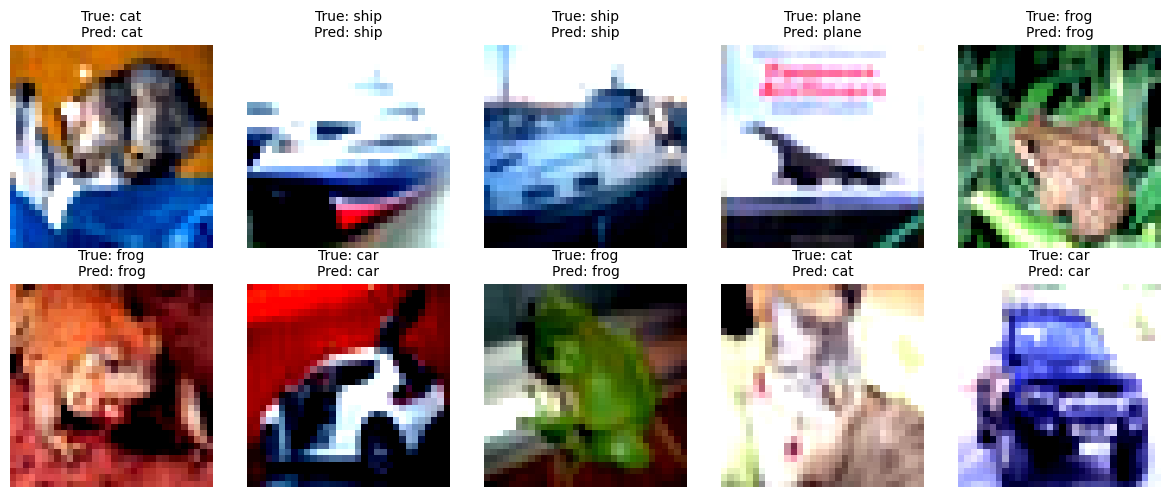

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize and print test sample predictions
def visualize_predictions(model, loader, device, class_names):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = outputs.max(1)

    # Convert images back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    fig, axs = plt.subplots(2, 5, figsize=(12, 5), dpi=100)
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        img = images[i]
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with CIFAR-10 class names
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
visualize_predictions(model, test_loader, device, class_names)


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Source path of the model
model_path = '/content/best_wrn_model.pth'

# Destination path in Google Drive (you can change the folder name)
destination_path = '/content/drive/My Drive/best_wrn_model.pth'

# Copy the model to Google Drive
shutil.copy(model_path, destination_path)

print(f'Model saved to {destination_path}')


Mounted at /content/drive
Model saved to /content/drive/My Drive/best_wrn_model.pth
